## Lab 3

### Part 2. Almost Shakespeare (2.0 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [ ]:
import string
import numpy as np

In [ ]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [ ]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.


text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [ ]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [ ]:
# словарь вида <индекс>:<символ>
# Your great code here
idx_to_token = dict(enumerate(tokens))

# словарь вида <символ>:<индекс>
# Your great code here
token_to_idx = {k:v for v,k in idx_to_token.items()}

In [ ]:
one_hot_dict = {i:t for i,t in token_to_idx.items()}
# one_hot_dict.setdefault([0 for i in range(38)])
for i in range(len(tokens)):
    vector = np.zeros(len(tokens))
    vector[i] = 1
    one_hot_dict[idx_to_token[i]] = vector

In [ ]:
def to_matrix(stroki, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    max_len = max_len or max(map(len, stroki))
    stroki_ix = np.zeros([len(stroki), max_len], dtype) + pad

    for i in range(len(stroki)):
        line_ix = [token_to_idx[c] for c in stroki[i]]
        stroki_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        stroki_ix = np.transpose(stroki_ix)

    return stroki_ix

In [ ]:
def to_matrix_2(stroki):
    matrix = np.zeros((len(stroki),38),dtype='int32')
    for i in range(len(stroki)):
            matrix[i,:] = one_hot_dict[stroki[i]]
    return matrix

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [ ]:

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=38, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)###YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)###YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [ ]:
char_rnn = CharRNNCell()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size,max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [ ]:
char_rnn = CharRNNCell()

In [ ]:
batch_ix = to_matrix_2(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

batch_ix.size()
logp_seq = rnn_loop(char_rnn, batch_ix)
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]
# print(actual_next_tokens[0])

    
#     loss  = nn.CrossEntropyLoss()
loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
loss
    
assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [ ]:
import random
from matplotlib import pyplot as plt

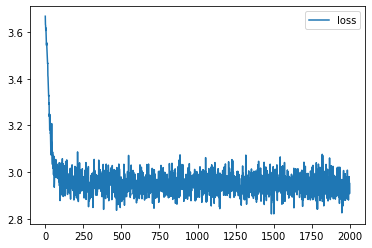

In [ ]:
MAX_LENGTH = 16
batch_size_mine = 4
for i in range(2000):
    
    pieces_of_text = []
    for k in range(batch_size_mine):
        ind = random.randint(0,10000)
        piece_of_text = text[ind:ind+100]
        pieces_of_text.append(piece_of_text)
    batch_ix = to_matrix(pieces_of_text).transpose()
#     ind = random.randint(0,10000)
#     piece_of_text = text_2[ind:ind+100]
#     batch_ix = to_matrix(piece_of_text,batch_first=False)
#     batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
#     loss  = nn.CrossEntropyLoss()
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_text_2(char_rnn = char_rnn, seed_phrase=' ', length = 20 , temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(length):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Постройте график функции потерь в зависимости от номера эпохи.

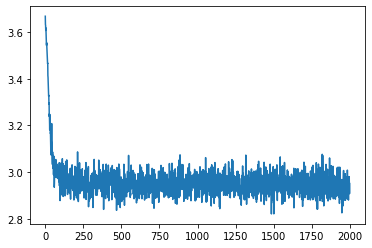

In [ ]:
# Your plot code here
plt.plot(history,label='loss')
plt.show()

In [ ]:
print(generate_text_2(seed_phrase= 'z ' ,length=100, temperature= 0.5))

z i   e n h         '  e    rt ee  otwr eaa  o  eo ei e  urse  e       d  she n e r at tete rie ns e  


### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [ ]:
# Your beautiful code here
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=38, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return Variable(torch.zeros(batch_size, self.num_units)), Variable(torch.zeros(batch_size, self.num_units))

In [ ]:
char_lstm = CharLSTMCell()
opt = torch.optim.Adam(char_lstm.parameters())
history = []

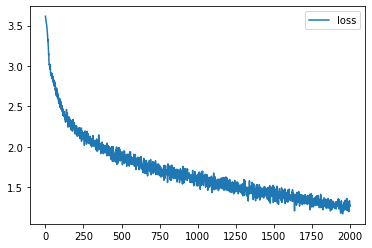

In [ ]:
batch_size = 10
for i in range(2000):
    
    pieces_of_text = []
    for k in range(batch_size):
        ind = random.randint(0,10000)
        piece_of_text = text[ind:ind+100]
        pieces_of_text.append(piece_of_text)
    batch_ix = to_matrix(pieces_of_text)
#     batch_ix = to_matrix(piece_of_text,batch_first=True)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_lstm, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
#     loss  = nn.CrossEntropyLoss()
#     loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens),  batch_ix[:, :-1].contiguous().view(-1))

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [ ]:

generate_text_2(char_lstm, ' ',length=100 , temperature= 0.3)

'   that thou shouldst and the trai self the so farted houssore and your self and thee the tor sume,\n '

In [ ]:
print('temperature = 0.1: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 0.1))
print('temperature = 0.2: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 0.2))
print('temperature = 0.5: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 0.5))
print('temperature = 1: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 1))

temperature = 0.1:  and the world to thou art shouldst thou and the world with thou self and the tormer's thee the world wit
temperature = 0.2:  and the tomment, then with beauty summer when the tor self the world be the world with thou art should t
temperature = 0.5:  and thy self ast not self in make then the stant should thy make of thy self the to do should that thou 
temperature = 1:  and time heagues thy plase 'stled they why shouldsed will pliven noot wail makstry finks need with wiver


Здесь можно оставить свои рассуждения касательно интерпретации результатов.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)